# Copper grains classification based on thermal images

This demo shows construction and usage of a neural network that classifies
copper grains.
The grains are recorded with a thermal camera using active thermovision
approach.
The network is fed with numbers of low emissivity spots on every stage of
cooling down the grain samples.
For more information about tracking and counting these spots refer to other
Jupyter demos in this project.

In [1]:
from inspect import getsource
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

from blob_series_tracker import count_blobs_with_all_methods
from img_processing import decode_labels, default_img_set, full_prepare
from neural_network import (default_grain_classifier_model,
                            network_cross_validation)


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Data preparation

Let's visualize how a sample image of grains looks like.
To start with we will load the whole default dataset, then we will select a
sample labeled as E5 class at the beginning of the colling process and show it.

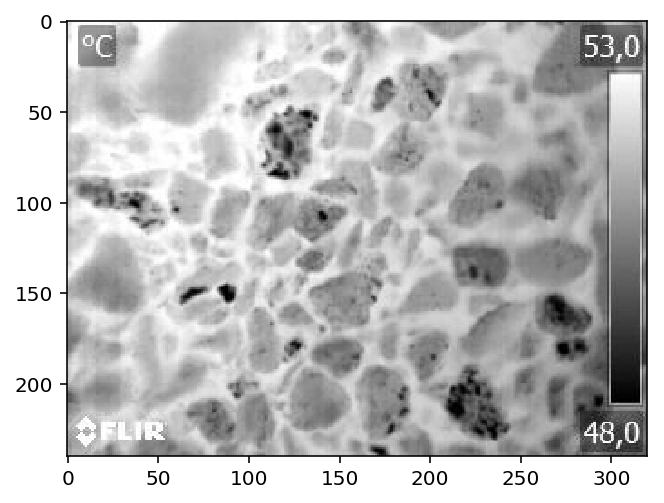

In [2]:
X, y = default_img_set()
plt.imshow(X[0][0]);

Next we will prepare the images for classification. They should be cropped to
remove the FLIR UI overlay.
Then they ought to be converted to grayscale and inverted.
The task is to track points with low thermal emissivity which are presented as
black spots on the image.
However multiple image processing algorithms treat white spots as foreground
features and black space as background.
This is opposite to the way in which colors display temperature on our image so
we have to invert the photo.
All these preparations are completed by a single function.

In [3]:
X = [[full_prepare(img) for img in same_sample] for same_sample in X]

Subsequently we have to track and count low emissivity blobs on each stage of
cooling the grains.
There are three ways of counting the spots:
*  counting all spots at every stage of cooling,
*  tracking blobs that are present from the begging of the cooling and ignoring
   blobs that appear later,
*  tracking blobs that are present from the begging of the cooling and
   calculating the ratio of remaining blobs to their initial number.

To inspect how these methods work relate to other Jupyter demos.
In this notebook we will simply implement a function that uses every one of
these approaches and compare results.

In [4]:
Xs = count_blobs_with_all_methods(X)

## Classification

We will write a function to classify given grains data.
We have three X datasets, one for every blob counting method.
Later we will call the classification demo function on each of them.

The function turns datasets into NumPy arrays as most of the libraries use this
container for computation efficiency.
Then the data is split into train and test sets.
A function from Scikit-learn is used to perform the split.
Notice that the function is given constant random seed to ensure repetitiveness
of the demo.
So the call looks like this:
```python
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.33, random_state=1)
```

### Neural network model

The classifier model is returned by the `default_grain_classifier_model` function.
Let's take a look at the model definition.

In [5]:
print(getsource(default_grain_classifier_model))

def default_grain_classifier_model():
    '''
    Get default uncompiled model for grain classifcation,
    based on 5 step cooling process using number of blobs.
    '''
    model = keras.Sequential([
        keras.layers.Dense(5, activation='tanh'),
        keras.layers.Dense(256, activation='tanh'),
        keras.layers.Dense(128, activation='tanh'),
        keras.layers.Dense(4, activation='softmax')
    ])
    return model



The model includes four layers, with two hidden ones.
The number of neurons in the input layer is equal to the size of the input
vector, that is five.
If you wish to know why the vector has this size, please refer to the other demo
notebooks.
The input is equal to the number of classes, in this case it is four.
Outputs of the network represent the probability of the input belonging to each
of the classes.
The number of the neurons in hidden layers and their activation functions were
chosen based on experiments.
You can examine the comparison of various network structures in the thesis.

### Network training

The last step of constructing a network is the training.
The model compiler has to be given `optimizer`, `loss` and `metrics` parameters
that define the training process.
The best loss function that calculates error between output of the network and
training label is the `sparse_categorical_crossentropy`.
During comparisons adam optimiser proved to be the best one, as it provides
adaptive learning rate.
The comparison of different network training parameters is included in the
thesis.

The `classification_demo` function implements the ideas presented above.
It also prints model evaluation on test set and prints training history.

In [6]:
def classification_demo(X, y):
    '''
    Demo grain classification on given data.
    Train and test default model.
    '''
    X = np.array(X)
    y = np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.33, random_state=3)

    model = default_grain_classifier_model()
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=300, verbose=0)

    print("Test y:", y_test)
    print("Test y:", [decode_labels(y) for y in y_test])
    print('Test prediction outputs:')
    classes = ('E5R', 'E6R', 'E11R', 'E16R')
    print(pd.DataFrame(model.predict(X_test), columns=classes, index=classes))
    prediction = model.predict_classes(X_test)
    print('Test prediction classification:\n', prediction)
    print('Test prediction classification:\n',
          [decode_labels(y) for y in prediction])
    print('Model evaluation loss and accuracy:\n',
          model.evaluate(X_test, y_test, verbose=0), '\n')
    return history

## Test results

Now we can use the function to print the results of classification.
The output is relatively lengthy, let's clarify it a bit.
It prints classes of test set in encoded and decoded form.
Then the prediction output for each test is shown.
The closer the output is to one, the more sure the network is that a sample
belongs to given class.
Then the predictions are presented in encoded and decoded format.
Each demo is summarized by the loss and accuracy scores.

The method of tracking and calculating ratio of blobs yield the best results.
Not only it has the highest scores, but also the output is more stable.
The first two methods of counting blobs cause the network to produce unstable
results.
The efficiency varies between each run of the training.
The last method of the data extraction yields the best and clearly visible
classes separation in the evaluation.
However, this way of validating the classifier is unreliable especially on the
extremely small data set.
This way of testing wastes one-third of the very limited data set and introduces
negative bias to the evaluation.
A better way of judging the efficiency of the network is presented later in the
notebook.

In [7]:
demo_names = ('All blobs detection',
              'Detect only remaining blobs',
              'Ratio of remaining blobs')
training_histories = []
for X, demo_name in zip(Xs, demo_names):
    print(demo_name)
    training_histories.append(classification_demo(X, y))

All blobs detection
Test y: [3 0 2 1]
Test y: ['E16R', 'E5R', 'E11R', 'E6R']
Test prediction outputs:
           E5R           E6R          E11R      E16R
E5R   0.000088  2.053345e-04  4.995573e-01  0.500149
E6R   0.999228  1.578969e-12  1.760408e-08  0.000772
E11R  0.999224  1.587597e-12  1.770039e-08  0.000776
E16R  0.999052  1.980504e-12  2.209740e-08  0.000948
Test prediction classification:
 [3 0 0 0]
Test prediction classification:
 ['E16R', 'E5R', 'E5R', 'E5R']
Model evaluation loss and accuracy:
 [11.372742748993915, 0.5] 

Detect only remaining blobs
Test y: [3 0 2 1]
Test y: ['E16R', 'E5R', 'E11R', 'E6R']
Test prediction outputs:
           E5R           E6R          E11R          E16R
E5R   0.000001  4.603295e-10  5.660361e-01  4.339629e-01
E6R   0.999137  8.625648e-04  2.193910e-07  5.237193e-07
E11R  0.000001  4.773795e-10  5.795143e-01  4.204847e-01
E16R  0.000163  9.962723e-01  1.495509e-05  3.549328e-03
Test prediction classification:
 [2 0 2 1]
Test prediction classifi

To investigate the network learning process and ensure it's propriety we can
plot the training history.
We will write a small helper function and plot accuracy and loss versus epochs.

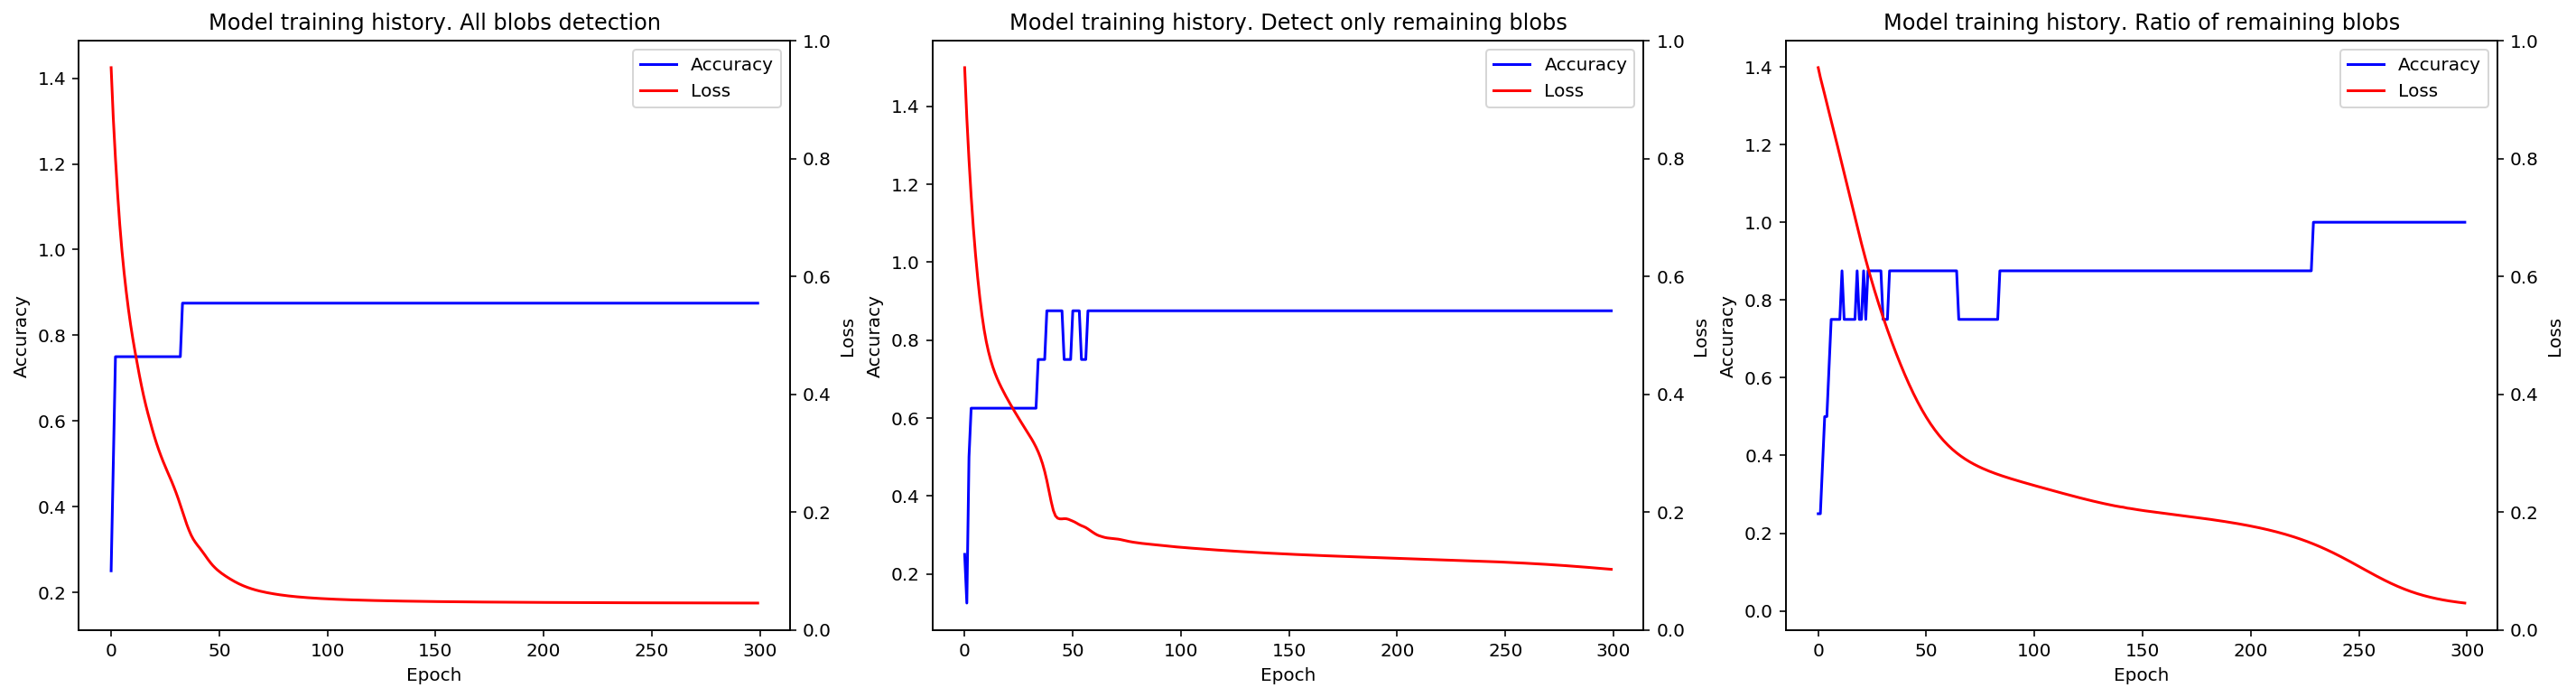

In [8]:
def plot_history(ax, history, demo_name):
    ax.title.set_text('Model training history. ' + demo_name)
    ax.set_xlabel('Epoch')

    lns1 = ax.plot(history.history['accuracy'], c='b', label='Accuracy');
    ax.set_ylabel('Accuracy')
    ax.twinx()
    lns2 = ax.plot(history.history['loss'], c='r', label='Loss');
    plt.ylabel('Loss')

    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs)

_, ax = plt.subplots(1, 3, figsize=(24, 6))
for a, history, name in zip(ax, training_histories, demo_names): 
    plot_history(a, history, name)

The plots are generated for networks employing different methods of counting blobs for feature extraction.
As could have been foreseen, the latter methods that make a use of blob tracking mechanisms have more clear shape, greater accuracy and smaller loss.

# Network validation

The results of the test presented above are fully conclusive.
The best way to validate the network and check if the idea of grains
classification does work is to perform cross-validation of the model.
This method splits the data k-times and performs the validation on each part of
train and test sets.
The ultimate result of validation is averaged.

Let's crate a function that will validate perform the cross-validation for every
way of blob counting.

In [9]:
def cross_val_demo(X, y):
    '''Demo cross validation of default grain classifier on given data.'''
    X = np.array(X)
    y = np.array(y)

    model = default_grain_classifier_model()
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    scores = network_cross_validation(model, X, y, 3)

    print('Folds scores: (loss, acc)\n', scores)
    scores = np.array(scores)
    print('Cross validation mean score (loss, acc):\n',
          scores.mean(axis=0), '\n')

The `network_cross_validation` takes the model to test, dataset and number of
splits to perform.
We can investigate it's implementation to see how it works.

In [10]:
print(getsource(network_cross_validation))

def network_cross_validation(model, X, y, n_splits):
    '''Compute cross validation fold scores for given keras model.'''
    eval_scores = []

    folds = StratifiedKFold(n_splits=n_splits).split(X, y)
    for train_index, test_index in folds:
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(x_train, y_train, epochs=300, verbose=0)
        eval_scores.append(model.evaluate(x_test, y_test, verbose=0))
    return eval_scores



Now we can perform the validation.
Notice that the accuracy of the last blob tracking method becomes stable 0.92,
which is a satisfactory result.
It should be preferred as the best way to classify copper grains.
The other methods of data extraction yield poor classification results and
should be rejected.

In [11]:
for X, demo_name in zip(Xs, demo_names):
    print(demo_name)
    cross_val_demo(X, y)

All blobs detection
Folds scores: (loss, acc)
 [[8.650588184595108, 0.25], [4.666504085063934, 0.25], [0.3054614175343886, 0.75]]
Cross validation mean score (loss, acc):
 [4.54085123 0.41666667] 

Detect only remaining blobs
Folds scores: (loss, acc)
 [[3.9184877690277062, 0.25], [0.3508455941628199, 0.75], [2.5576355306353094, 0.5]]
Cross validation mean score (loss, acc):
 [2.2756563 0.5      ] 

Ratio of remaining blobs
Folds scores: (loss, acc)
 [[0.06772129192813736, 1.0], [4.375062700837148, 0.75], [0.030403532480931972, 1.0]]
Cross validation mean score (loss, acc):
 [1.49106251 0.91666667] 



## Conclusion

The results of the validation proved that the copper grains can be classified
using active thermography approach.
The classifier has been tested and trained on a extremely small dataset.
However the results show that the suggested idea is worth further investigation.
The next steps in the project may include creating larger dataset with enhanced
measurement stand and development of a more advanced neural network, such as
convolutional neural network.